In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

# Set seed for reproducibility
np.random.seed(0)

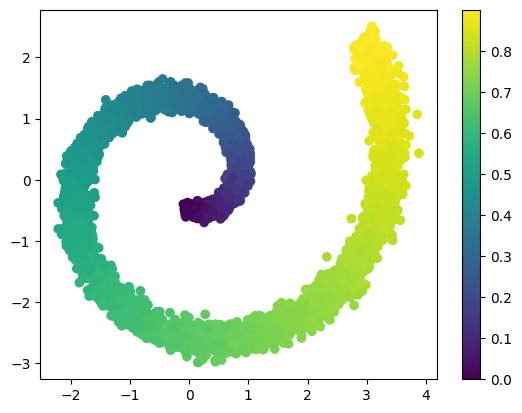

In [46]:
X, color = make_swiss_roll(n_samples=10000, noise=0.5, random_state=0)
X = X[:,[0,2]]/10 # drop 3rd dimension
color = (color-color.min())/(color.max()-color.min())
cut = 0.9
X = X[color < cut]
color = color[color < cut]
X = X*(1+2*color[:,np.newaxis])

plt.scatter(*X.T, c=color)
plt.colorbar()

In [47]:
import keras
from keras import layers
from keras.optimizers import Adam
from keras.regularizers import l2

from keras.callbacks import ModelCheckpoint

# Set up the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_model.keras',    # Path where the model will be saved
    monitor='loss',    # Save based on the validation loss
    verbose=1,             # Log message verbosity
    save_best_only=True,   # Only save the model if `val_loss` has improved
    mode='min',            # `min` mode means the callback focuses on minimizing `val_loss`
    save_freq='epoch')     # Save at the end of every epoch

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='loss',      # Metric to monitor
    min_delta=0.001,         # Minimum change to qualify as an improvement
    patience=50,             # Number of epochs to wait before stopping
    verbose=1,               # Logging level
    mode='min',              # The training will stop when the quantity monitored has stopped decreasing
    restore_best_weights=True)  # Whether to restore model weights from the epoch with the best value of the monitored quantity.

from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='loss',     # Metric to monitor
    factor=0.3,             # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=25,             # Number of epochs with no improvement after which learning rate will be reduced.
    verbose=1,              # int. 0: quiet, 1: update messages.
    mode='min',             # one of {min, max}. In 'min' mode, lr will be reduced when the quantity monitored has stopped decreasing; in 'max' mode it will increase when the quantity monitored has stopped increasing.
    min_delta=0.0001,       # threshold for measuring the new optimum, to only focus on significant changes.
    cooldown=0,             # number of epochs to wait before resuming normal operation after lr has been reduced.
    min_lr=0                # lower bound on the learning rate.
)


In [48]:
L2 = l2(0.0)

encoder = keras.Sequential([
    layers.Dense(units=128, activation='relu', kernel_regularizer=L2, input_shape=(2,)),
    layers.Dense(units=16, activation='relu', kernel_regularizer=L2),
    layers.Dense(units=16, activation='relu', kernel_regularizer=L2),
    layers.Dense(units=1, activation='sigmoid', kernel_regularizer=L2)
    ], name="encoder")


decoder = keras.Sequential([
    layers.Dense(units=128, activation='tanh', kernel_regularizer=L2, input_shape=(1,)),
    layers.Dense(units=16, activation='tanh', kernel_regularizer=L2),
    layers.Dense(units=4,  activation='tanh', kernel_regularizer=L2),
    layers.Dense(units=2, activation='linear', kernel_regularizer=L2)
    ], name="decoder")


autoencoder = keras.Sequential([encoder, decoder], name="autoencoder")


autoencoder.compile(optimizer=Adam(learning_rate=.01),
    loss='mse',
    metrics=['accuracy'])


autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 1)                 2737      
                                                                 
 decoder (Sequential)        (None, 2)                 2398      
                                                                 
Total params: 5135 (20.06 KB)
Trainable params: 5135 (20.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
history = autoencoder.fit(X, X,
                    batch_size=100,
                    epochs=1000,
                    callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/1000
84/90 [===========================>..] - ETA: 0s - loss: 0.9036 - accuracy: 0.8839
Epoch 1: loss improved from inf to 0.88286, saving model to best_model.keras
90/90 [==============================] - 2s 5ms/step - loss: 0.8829 - accuracy: 0.8884 - lr: 0.0100
Epoch 2/1000
85/90 [===========================>..] - ETA: 0s - loss: 0.4623 - accuracy: 0.9261
Epoch 2: loss improved from 0.88286 to 0.45455, saving model to best_model.keras
90/90 [==============================] - 1s 7ms/step - loss: 0.4546 - accuracy: 0.9252 - lr: 0.0100
Epoch 3/1000
86/90 [===========================>..] - ETA: 0s - loss: 0.3226 - accuracy: 0.8610
Epoch 3: loss improved from 0.45455 to 0.31902, saving model to best_model.keras
90/90 [==============================] - 1s 7ms/step - loss: 0.3190 - accuracy: 0.8621 - lr: 0.0100
Epoch 4/1000
87/90 [============================>.] - ETA: 0s - loss: 0.1912 - accuracy: 0.8989
Epoch 4: loss improved from 0.31902 to 0.19013, saving model to best_model.ke

In [41]:
from keras.models import load_model

model = load_model('best_model.keras')
encoder = model.submodules[2]
decoder = model.submodules[1]

79/79 [==============================] - 0s 2ms/step


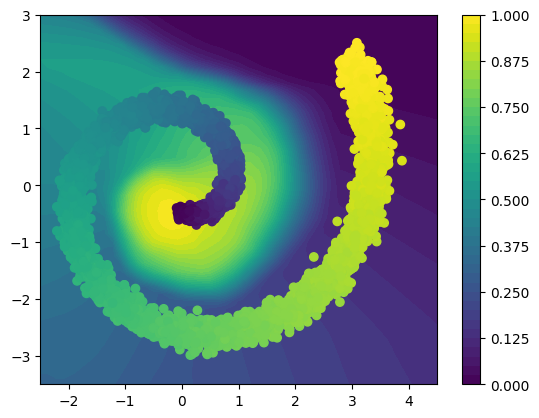

In [51]:
X_grid, Y_grid = np.meshgrid(np.linspace(-2.5,4.5), np.linspace(-3.5,3.0))
grid_points = np.stack([X_grid.flatten(), Y_grid.flatten()]).T

grid_preds = encoder.predict(grid_points)

plt.contourf(X_grid, Y_grid, grid_preds.reshape(X_grid.shape), 40, vmin=0, vmax=1)
plt.colorbar()
plt.scatter(*X.T, c=color)
plt.savefig('encoder.png', bbox_inches='tight')

282/282 [==============================] - 1s 3ms/step


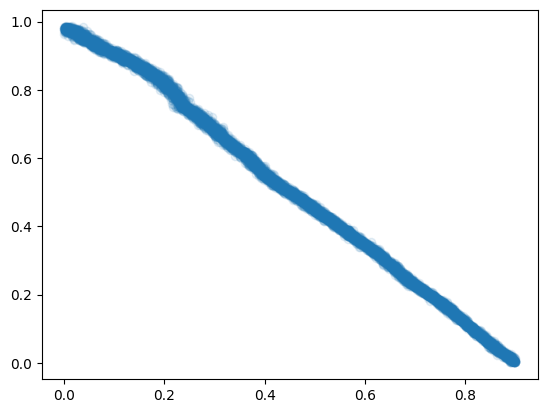

In [59]:
z_pred = encoder.predict(X)

plt.scatter(color, z_pred, alpha=0.1)

In [71]:
z_synthetic = np.linspace(0,1,401).reshape((-1,1))
print(z_synthetic[:6])

y_synthetic = decoder.predict(z_synthetic)

[[0.    ]
 [0.0025]
 [0.005 ]
 [0.0075]
 [0.01  ]
 [0.0125]]
13/13 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 32ms/step


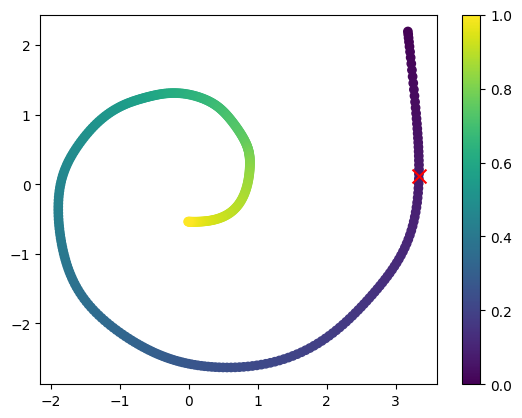

In [84]:

plt.scatter(*y_synthetic.T, c=z_synthetic)
plt.colorbar()

z_samp = np.random.random()
y_generated = decoder.predict([[z_samp]])
plt.scatter(*y_generated[0], s=100, marker='x', color='r')

plt.show()

In [ ]:
plt.scatter(*X.T)

plt.scatter(*y_synthetic.T)

plt.show()